# A/B–тестирование новой механики оплаты

В рамках проверки одной из гипотез целевой аудитории была предложена новая механика оплаты на сайте, в то время как у контрольной группы сохранился прежний вариант. Далее будет представлен анализ результатов эксперимента и на их основе даны выводы о том, целесообразно ли внедрять новую механику оплаты для всех пользователей.

# Подготовка данных

In [5]:
import pandas as pd
from scipy.stats import chi2_contingency, levene, ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt

Читаем исходные файлы

In [7]:
groups = pd.read_csv('Final_project/Проект_2_groups.csv', sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [9]:
groups_add = pd.read_csv('Final_project/Проект_2_group_add.csv')
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [10]:
checks = pd.read_csv('Final_project/Проект_2_checks.csv', sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [11]:
active_studs = pd.read_csv('Final_project/Проект_2_active_studs.csv')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


### Изучаем исходные файлы (проверяем наличие null значений, дублей, тип данных и размеры датафрейма)

In [12]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [13]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [14]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [15]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


В данных нет null значений, преобразование данных не требуется.

In [16]:
groups.duplicated().sum()

np.int64(0)

In [17]:
groups_add.duplicated().sum()

np.int64(0)

In [18]:
active_studs.duplicated().sum()

np.int64(0)

In [19]:
checks.duplicated().sum()

np.int64(0)

Нет дублирующихся данных

### Объединение данных в единый датасет для дальнейшего анализа

Объдиняем данные с изначальными группами пользователей с датафреймом, который предоставили через 2 дня. Проверяем на дубли

In [20]:
new_groups = pd.concat([groups, groups_add], ignore_index=True)

In [21]:
new_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [22]:
new_groups.duplicated().sum() #дублей нет

np.int64(0)

Оставляем в объединненом датафрейме информацию только об активных пользователях в дни проведения эксперимента путем объединения с датафреймом active_studs

In [23]:
active_studs = active_studs.rename(columns={'student_id':'id'})

In [24]:
df_active = active_studs.merge(new_groups, on='id', how='left')

In [25]:
df_active.head() #только активные пользователи

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


Объединяем активных пользователей и совершивших покупку

In [26]:
checks = checks.rename(columns={'student_id':'id'})

In [27]:
full_df = df_active.merge(checks, on='id', how='left')
full_df.head()

,id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


Проверяем получившийся датафрейм

In [28]:
full_df.info() #количество строк совпадает с изначальным дф active_studs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8341 non-null   int64  
 1   grp     8341 non-null   object 
 2   rev     392 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 195.6+ KB


In [29]:
full_df.duplicated().sum() #дублей нет

np.int64(0)

In [30]:
full_df.groupby(full_df['rev'].isnull()).size() #смотрим количество платящих и неплатящих
#Количество платящих пользователей отличается от изначального количества платящих в дф checks

rev
False     392
True     7949
dtype: int64

In [31]:
541-392

149

Вероятно, произошла ошибка в процессе сбора данных: либо в датафрейм checks попали оплаты, совершенные не в дни эксперимента, либо не все платящие пользователи (совершившие оплату в дни проведения эксперимента) попали в датафрейм active_studs (соответственно и некоторые пользователи, которые были активны в дни эксперимента, могли не отметиться как активные)

In [32]:
full_df.groupby('grp', as_index=False) \
        .agg({'id':'nunique'})

,grp,id
0,A,1538
1,B,6803


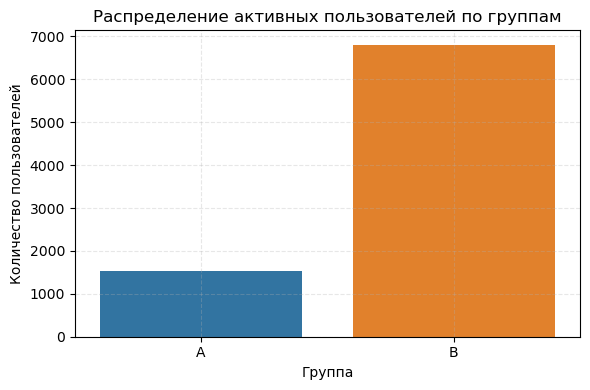

In [50]:
#распределение активных пользователей по группам
plt.figure(figsize=(6, 4))
sns.countplot(data=full_df, x='grp', hue='grp')
plt.xlabel('Группа', fontsize=10)
plt.ylabel('Количество пользователей', fontsize=10)
plt.title('Распределение активных пользователей по группам', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

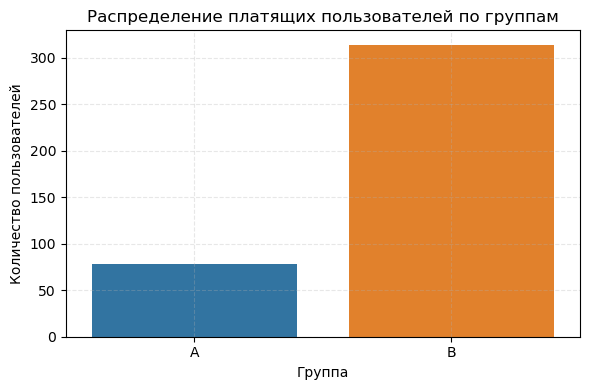

In [47]:
#распределение платящих пользователей по группам
plt.figure(figsize=(6, 4))
sns.countplot(data=full_df.query('rev > 0'), x='grp', hue='grp')
plt.xlabel('Группа', fontsize=10)
plt.ylabel('Количество пользователей', fontsize=10)
plt.title('Распределение платящих пользователей по группам', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

Необходимо проверить правильность составления выборок, сейчас в тестовой группе значительно больше пользователей, чем в контрольной

In [51]:
A_group = full_df.query('grp=="A"')

In [52]:
B_group = full_df.query('grp=="B"')

# Анализ итогов эксперимента

В качестве метрик для анализа итогов A/B теста выбираем конверсию в оплату и среднюю выручку на одного пользователя (ARPU), так как они напрямую влияют на финансовые результаты эксперимента и общую выручку компании

### Гипотеза №1

H0: Новая механика оплаты не влияет на конверсию в оплату на сайте

H1: Новая механика оплаты влияет на конверсию в оплату на сайте

Метрика для анализа: CR в оплату

In [55]:
((A_group.rev.count() / A_group.id.count())*100).round(3) #конверсия в оплату в группе A

np.float64(5.072)

In [56]:
((B_group.rev.count() / B_group.id.count())*100).round(3) #конверсия в оплату в группе B

np.float64(4.616)

Конверсия в оплату выше в контрольной группе A (5,07% в группе A и 4,62% в группе B), но разница в значениях конверсий в оплату в группах A и B может быть обусловлена разным объемом выборок. Нужно провести статистический тест, чтобы проверить есть ли значимые различия

Для выявления статистической значимости в различиях показателей конверсии в оплату в группах A и B применим тест Хи-квадрат

Используем Хи-квадрат, потому что оцениваем категориальные переменные (отличается ли частота покупок (оплатил/не оплатил) в группе с новой механикой оплаты по сравнению с контрольной группой)

Составляем таблицу сопряженности по оплатившим и не оплатившим пользователям

In [57]:
full_df['paid'] = full_df.rev.notna().astype(int)

In [58]:
cross_table = pd.crosstab(full_df['grp'], full_df['paid']) #где 0 - не оплатил, 1 - оплатил
cross_table

paid,0,1
grp,,
A,1460,78
B,6489,314


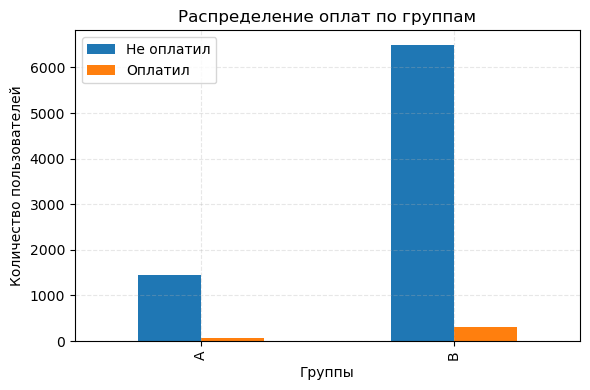

In [62]:
cross_table.plot(kind='bar', figsize=(6, 4))
plt.title('Распределение оплат по группам')
plt.xlabel('Группы')
plt.ylabel('Количество пользователей')
plt.legend(labels=['Не оплатил', 'Оплатил'])
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

In [63]:
chi2, p_value, dof, expected = chi2_contingency(cross_table)

In [64]:
p_value #не выявлено статистической значимости влияния новой механики оплаты на конверсию в оплату

np.float64(0.48625240457231045)

### Вывод

По итогам проведенного статистического исследования с использованием критерия хи-квадрат не обнаружено статистически значимых различий в конверсии в оплату между контрольной (группа A) и тестовой (группа B) выборками. Рассчитанное p-value = 0.486, что превышает уровень значимости (p > 0.05). Наблюдаемые расхождения в показателях конверсии в оплату могут быть обусловлены случайными факторами и не свидетельствуют о наличии значимого эффекта от тестируемых изменений.

### Гипотеза №2

H0: Новая механика оплаты не влияет на среднюю выручку с пользователя

H1: Новая механика оплаты влияет на среднюю выручку с пользователя

Метрика для анализа: ARPU

1. Рассчитаем сумму выручки в каждой из групп

In [65]:
full_df.groupby('grp', as_index=False) \
        .agg({'rev':'sum'})

,grp,rev
0,A,72820.0000
1,B,394974.0035


2. Посмотрим основную статистику по выручке для каждой из групп

In [66]:
A_group.rev.describe() #статистика выручки в группе A

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [67]:
B_group.rev.describe() #статистика выручки в группе B

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

3. Рассчитаем ARPU для каждой из групп

In [68]:
(A_group.rev.sum() / A_group.id.count()).round(2) # значение ARPU в группе A

np.float64(47.35)

In [69]:
(B_group.rev.sum() / B_group.id.count()).round(2) # значение ARPU в группе B

np.float64(58.06)

4. Представим визуально распределение выручки с помощью гистограммы и боксплота

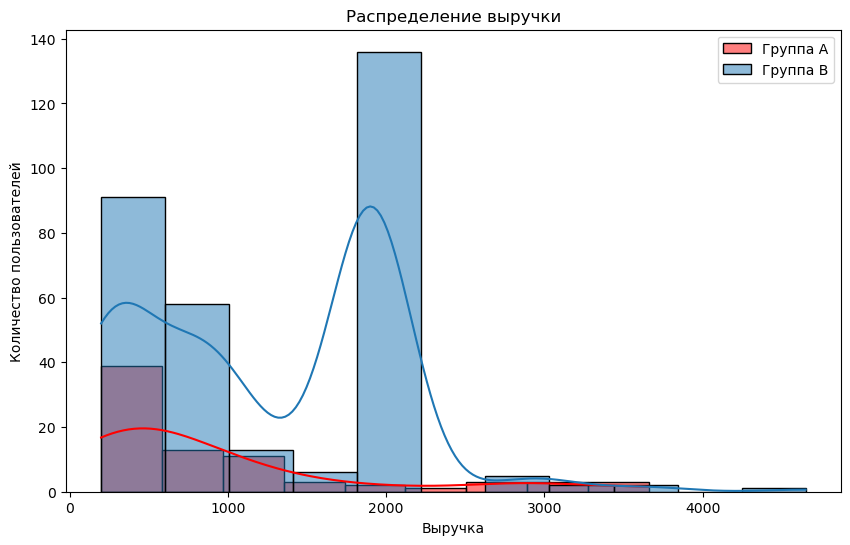

In [72]:
plt.figure(figsize=(10,6))
sns.histplot(A_group.rev.dropna(), kde=True, label='Группа A', color='red')
sns.histplot(B_group.rev.dropna(), kde=True, label='Группа B')
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Количество пользователей')
plt.legend()

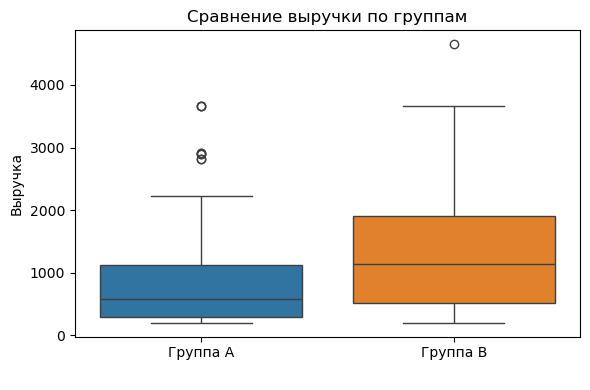

In [81]:
plt.figure(figsize=(6,4))
sns.boxplot(data=full_df, x='grp', y='rev', hue='grp')
plt.title('Сравнение выручки по группам')
plt.xticks([0,1], ['Группа A', 'Группа B'])
plt.xlabel(' ')
plt.ylabel('Выручка')
plt.tight_layout()

Основные показатели (среднее, медиана выручки) и ARPU выше в группе B.  
В группе A пользователи чаще совершают покупки на более низкий чек, чем в группе B, соответственно ARPU и общая выручка в группе B выше.  
Для того чтобы проверить значимость этих различий, применим статистический тест:

На основе графиков можно сделать вывод, что распределения не подчиняются нормальному

Проверим однородность диспресий с помощью теста Левена  
H0: Диспресии групп равны  
H1: Дисперсии групп не равны

In [82]:
stat_lev, p_lev = levene(A_group.rev.fillna(0), B_group.rev.fillna(0))
print(f"p-value = {p_lev:.4f}")

p-value = 0.2205


Поскольку p_value > 0.05 мы не можем отклонить нулевую гипотезу, предполагаем, что дисперсии однородны

3. В качестве статистического теста можем использовать двухвыборочный t-test, так как:  
    - несмотря на ненормальность распределения объемы выборок позволяют полагаться на центральную предельную теорему  
    - дисперсии однородны
    - сравниваем значения двух независимых групп

In [83]:
stat_tt, p_tt = ttest_ind(A_group.rev.fillna(0), B_group.rev.fillna(0))
print(f"p-value = {p_tt:.4f}")

p-value = 0.2205


Поскольку p_value > 0.05 мы не можем отклонить нулевую гипотезу, предполагаем, что новая механика оплаты не влияет на ARPU

### Вывод:

По результатам проведенного статистического анализа с использованием двухвыборочного t-теста не выявлено статистически значимых различий в показателе ARPU между тестовой (группа B) и контрольной (группа A) выборками. Полученное p-value = 0.2205, что превышает уровень значимости (p > 0.05). Внедренная новая механика оплаты не оказывает статистически значимого влияния на показатель средней выручки с пользователя (ARPU). Следовательно, имеющиеся различия в значениях ARPU между группами A и B могут быть объяснены случайными факторами и не свидетельствуют о наличии реального эффекта от внесённых изменений.

# Итоги эксперимента

Внедренная новая механика оплаты не оказывает статистически значимого влияния на ключевые метрики продукта:

1. Отсутствуют существенные различия в конверсии в оплату (CR) между тестовой и контрольной группами

2. Не выявлено значимых изменений в показателе средней выручки с пользователя (ARPU)

Перед принятием окончательного решения нужно провести проверку качества сбора данных и формирования выборок